In [1]:
!pip install kagglehub
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 1. Cargar y Preprocesar los Datos

In [2]:
# Descargar la última versión del dataset "jena-climate" y obtener la ruta de los archivos
path = kagglehub.dataset_download("mnassrib/jena-climate")
print("Path to dataset files:", path)

# Cargar el archivo CSV
data_file = f"{path}/jena_climate_2009_2016.csv"
data = pd.read_csv(data_file)

# Mostrar información básica del dataset
print(data.head())
print(data.describe())

# Separar entradas y salidas
inputs1, inputs2, outputs = data.iloc[:, 1], data.iloc[:, 5:15], data.iloc[:, 2]

# Concatenar entradas y rellenar valores faltantes
inputs = pd.concat([inputs1, inputs2], axis=1)
inputs = inputs.fillna(inputs.mean())

# Convertir a numpy
X = inputs.to_numpy()
y = outputs.to_numpy()

100%|██████████| 13.2M/13.2M [00:01<00:00, 7.95MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mnassrib/jena-climate/versions/1
             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

# Visualización de la Temperatura en el Tiempo

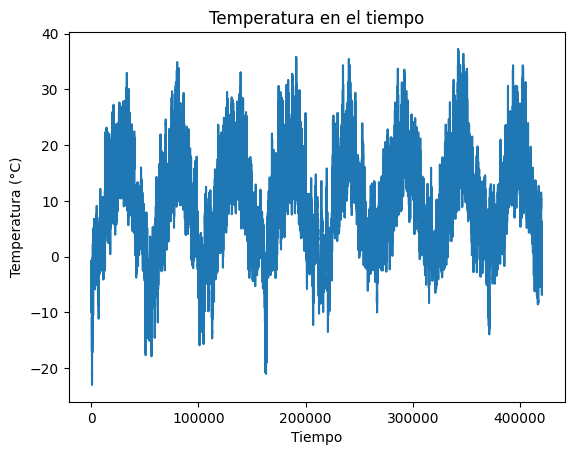

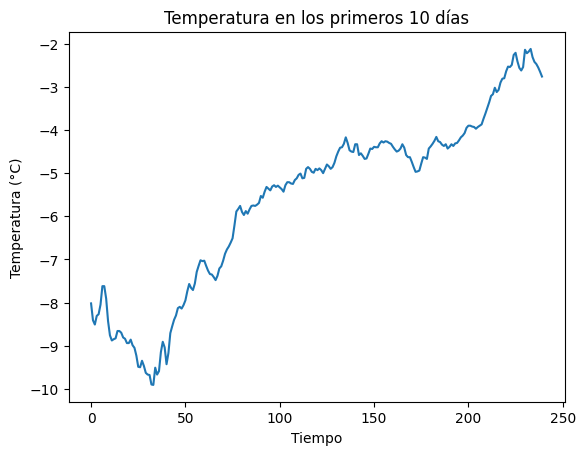

In [3]:
# Gráfico de toda la serie temporal
plt.plot(range(len(y)), y)
plt.title("Temperatura en el tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")
plt.show()

# Gráfico de los primeros 10 días
plt.plot(range(240), y[:240])
plt.title("Temperatura en los primeros 10 días")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura (°C)")
plt.show()

# División de los Datos

In [4]:
No_train = 210275
No_val = 105138
No_test = 105138

# Normalización basada en el conjunto de entrenamiento
media = X[0:No_train].mean(axis=0)
std = X[0:No_train].std(axis=0)
X = (X - media) / std

# Creación de Batches de Series Temporales

In [5]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=0, end_index=No_train)

val_dataset = keras.utils.timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train, end_index=No_train + No_val)

test_dataset = keras.utils.timeseries_dataset_from_array(
    X[:-delay], targets=y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train + No_val)


# Implementación del Modelo LSTM y Ajuste de Hiperparámetros

In [6]:
# Modelo LSTM Apilado con ajustes
model_LSTM2 = Sequential([
    Input(shape=(sequence_length, X.shape[-1])),
    LSTM(64, recurrent_dropout=0.2, return_sequences=True),
    LSTM(64, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(1)
])

# Compilar el modelo con un optimizador Adam y menor tasa de aprendizaje
model_LSTM2.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Callback de parada temprana para evitar el sobreajuste
early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Entrenar el modelo
history_LSTM2 = model_LSTM2.fit(
    train_dataset,
    epochs=30,  # Incremento en número de épocas
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


Epoch 1/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 399s 480ms/step - loss: 78.3718 - mae: 6.8407 - val_loss: 21.4032 - val_mae: 3.5193
Epoch 2/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 387s 472ms/step - loss: 23.1701 - mae: 3.7134 - val_loss: 13.8374 - val_mae: 2.8391
Epoch 3/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 387s 472ms/step - loss: 16.3409 - mae: 3.1272 - val_loss: 11.2136 - val_mae: 2.5681
Epoch 4/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 445s 475ms/step - loss: 13.8200 - mae: 2.8945 - val_loss: 10.1680 - val_mae: 2.4548
Epoch 5/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 471s 511ms/step - loss: 12.6183 - mae: 2.7759 - val_loss: 9.7348 - val_mae: 2.4077
Epoch 6/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 385s 470ms/step - loss: 11.9603 - mae: 2.7054 - val_loss: 9.5299 - val_mae: 2.3848
Epoch 7/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 385s 469ms/step - loss: 11.5490 - mae: 2.6606 - val_loss: 9.3760 - val_mae: 2.3698
Epoch 8/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 391s 477ms/step - loss: 11.2340 - mae: 2.6205 - val_loss: 9.2900 - val_mae: 2.3591
Epoch 9/30
8

# Evaluación y Visualización de Resultados

MAE= 2.4


405/405 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - loss: 9.9555 - mae: 2.4785
Test MAE (LSTM Apilado Mejorado): 2.48


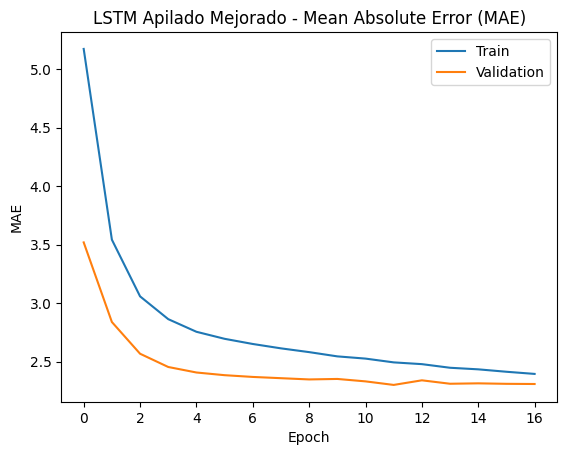

In [7]:
# Evaluar el modelo en el conjunto de prueba
print(f"Test MAE (LSTM Apilado Mejorado): {model_LSTM2.evaluate(test_dataset)[1]:.2f}")

# Curva de aprendizaje
plt.figure()
plt.plot(history_LSTM2.history['mae'])
plt.plot(history_LSTM2.history['val_mae'])
plt.title('LSTM Apilado Mejorado - Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()